In [9]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import scipy as sp
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [3]:
#We have used lemmatization and removed stop words if any

def text_process(text):
    lemmatiser = WordNetLemmatizer() 
    not_punct = [char for char in text if char not in string.punctuation]
    not_punct = ''.join(not_punct)
    a = ''
    i = 0
    for i in range(len(not_punct.split())):
        b = lemmatiser.lemmatize(not_punct.split()[i], pos="v")
        a = a + b + ' '

    not_stopwords = ""
    for word in a.split():
        if word.lower():
            not_stopwords = not_stopwords + word + " "
    
    return not_stopwords

In [4]:
#We have processed the text, where we have dropped rows having NaN values and used text_process function

df = pd.read_csv("./Enron_29_Features.csv").drop(["Unnamed: 0"], axis=1)
df = df[df["Email Length"].notna()]
df = df[df["Author"].notna()]
cleaned_text = df["Text"].apply(lambda row: text_process(row))
df["Processed Text"] = cleaned_text

In [5]:
#We have used LabelEncoder() to encode the class names

y = df["Folder"]
le = LabelEncoder()
y = le.fit_transform(y)

#Dropped all unrequired columns/attributes

X = df.drop(["Author", "File", "Raw Text", "Message ID", "Folder", "Text"], axis=1)

#Dropped rows having NaN values

X = X[X["Email Length"] != 0]
X = X[X["Average Word Length"].notna()]
X = X[X["Most Common Word"].notna()]
X = X.reset_index(drop=True)

In [6]:
#We are checking if still any NaN values are present, dropping if present and printing the shape after the change

for column in X.columns:
    if X[column].dropna().shape[0] != X.shape[0]:
        print(column)
        print(X[column].dropna().shape)

In [13]:
#Decision Tree Model -

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = DecisionTreeClassifier(random_state=0)
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", CountVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(score_func=mutual_info_classif, k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=6000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)
    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1
    

Y_pred = fit_model.predict(X_test_transform)
f1_dt = f1_score(y_test, Y_pred, average = "micro")
avg_train_acc_dt = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_dt = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_dt)
print("Average Testing Accuracy:")
print(avg_test_acc_dt)
print("F1 Score:")
print(f1_dt)
print("===========================")

Round 1
Training Accuracy
0.9904156915190014
Testing Accuracy
0.819047619047619
Round 2
Training Accuracy
0.9903605059341394
Testing Accuracy
0.8094282848545636
Round 3
Training Accuracy
0.9904719451718951
Testing Accuracy
0.8104312938816449
Round 4
Training Accuracy
0.9909177021229175
Testing Accuracy
0.8234704112337011
Round 5
Training Accuracy
0.9900261882208725
Testing Accuracy
0.8144433299899699
Round 6
Training Accuracy
0.9899704686019948
Testing Accuracy
0.8074222668004012
Round 7
Training Accuracy
0.9901376274586282
Testing Accuracy
0.8044132397191575
Round 8
Training Accuracy
0.9907505432662841
Testing Accuracy
0.8149448345035105
Round 9
Training Accuracy
0.9898033097453613
Testing Accuracy
0.8224674022066198
Round 10
Training Accuracy
0.9895804312698501
Testing Accuracy
0.8094282848545636
Average Training Accuracy:
0.9902434413310944
Average Testing Accuracy:
0.8135496967091752
F1 Score:
0.8094282848545635


In [14]:
#Multinomial Naive Bayes Model -

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = MultinomialNB()
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", CountVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(score_func=mutual_info_classif, k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=6000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1
    

Y_pred = fit_model.predict(X_test_transform)
f1_mnb = f1_score(y_test, Y_pred, average = "micro")
avg_train_acc_mnb = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_mnb = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_mnb)
print("Average Testing Accuracy:")
print(avg_test_acc_mnb)
print("F1 Score:")
print(f1_mnb)
print("===========================")

Round 1
Training Accuracy
0.8414688509974367
Testing Accuracy
0.8285714285714286
Round 2
Training Accuracy
0.8387474229676269
Testing Accuracy
0.831494483450351
Round 3
Training Accuracy
0.8399732545829387
Testing Accuracy
0.8284854563691073
Round 4
Training Accuracy
0.8411433665793726
Testing Accuracy
0.8174523570712137
Round 5
Training Accuracy
0.8390817406808937
Testing Accuracy
0.820962888665998
Round 6
Training Accuracy
0.8383573856354822
Testing Accuracy
0.8294884653961886
Round 7
Training Accuracy
0.8379673483033376
Testing Accuracy
0.8034102306920762
Round 8
Training Accuracy
0.8393603387752828
Testing Accuracy
0.8104312938816449
Round 9
Training Accuracy
0.8423691981946844
Testing Accuracy
0.8370110330992979
Round 10
Training Accuracy
0.8404190115339611
Testing Accuracy
0.820962888665998
Average Training Accuracy:
0.8398887918251017
Average Testing Accuracy:
0.8228270525863305
F1 Score:
0.820962888665998


In [15]:
#Random Forest Classifier Model -
# Average Training Accuracy:
# 0.9902434413310944
# Average Testing Accuracy:
# 0.8715713053948815

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = RandomForestClassifier(random_state=3)
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", CountVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(score_func=mutual_info_classif, k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=6000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1

Y_pred = fit_model.predict(X_test_transform)
f1_rf = f1_score(y_test, Y_pred, average = "micro")    
avg_train_acc_rf = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_rf = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_rf)
print("Average Testing Accuracy:")
print(avg_test_acc_rf)
print("F1 Score:")
print(f1_rf)
print("===========================")

Round 1
Training Accuracy
0.9904156915190014
Testing Accuracy
0.8791979949874686
Round 2
Training Accuracy
0.9903605059341394
Testing Accuracy
0.8771313941825476
Round 3
Training Accuracy
0.9904719451718951
Testing Accuracy
0.8716148445336008
Round 4
Training Accuracy
0.9909177021229175
Testing Accuracy
0.870110330992979
Round 5
Training Accuracy
0.9900261882208725
Testing Accuracy
0.8756268806419257
Round 6
Training Accuracy
0.9899704686019948
Testing Accuracy
0.8645937813440321
Round 7
Training Accuracy
0.9901376274586282
Testing Accuracy
0.8671013039117352
Round 8
Training Accuracy
0.9907505432662841
Testing Accuracy
0.8721163490471414
Round 9
Training Accuracy
0.9898033097453613
Testing Accuracy
0.8751253761283851
Round 10
Training Accuracy
0.9895804312698501
Testing Accuracy
0.8681043129388164
Average Training Accuracy:
0.9902434413310944
Average Testing Accuracy:
0.8720722568708632
F1 Score:
0.8681043129388164


In [16]:
#Support Vector Classification Model -

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = svm.SVC(kernel = 'linear')
train_accuracies = []
test_accuracies = []

i = 1
for train_index, test_index in kfold.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", CountVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(score_func=mutual_info_classif, k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=6000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    fit_model = model.fit(X_train_transform, y_train)
    train_acc = model.score(X_train_transform, y_train)
    test_acc = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(train_acc)
    print("Testing Accuracy")
    print(test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    i = i + 1
    

Y_pred = fit_model.predict(X_test_transform)
f1_svc = f1_score(y_test, Y_pred, average = "micro")
avg_train_acc_svc = sum(train_accuracies)/len(train_accuracies)
avg_test_acc_svc = sum(test_accuracies)/len(test_accuracies)
print("===========================")
print("Average Training Accuracy:")
print(avg_train_acc_svc)
print("Average Testing Accuracy:")
print(avg_test_acc_svc)
print("F1 Score:")
print(f1_svc)
print("===========================")

Round 1
Training Accuracy
0.9626100523793603
Testing Accuracy
0.8611528822055138
Round 2
Training Accuracy
0.9614420237365576
Testing Accuracy
0.8796389167502507
Round 3
Training Accuracy
0.9626121357329915
Testing Accuracy
0.8570712136409228
Round 4
Training Accuracy
0.9621106591630914
Testing Accuracy
0.854062186559679
Round 5
Training Accuracy
0.9614420237365576
Testing Accuracy
0.8681043129388164
Round 6
Training Accuracy
0.9609962667855352
Testing Accuracy
0.8585757271815446
Round 7
Training Accuracy
0.9608848275477796
Testing Accuracy
0.8520561685055166
Round 8
Training Accuracy
0.9630021730651362
Testing Accuracy
0.8485456369107321
Round 9
Training Accuracy
0.9611077060232908
Testing Accuracy
0.8741223671013039
Round 10
Training Accuracy
0.9614977433554355
Testing Accuracy
0.8610832497492478
Average Training Accuracy:
0.9617705611525735
Average Testing Accuracy:
0.8614412661543526
F1 Score:
0.8610832497492478


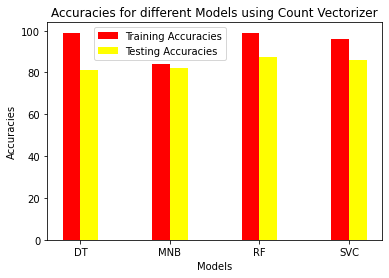

In [17]:
#We will plot the graph to show the comparision between the accuracies for different models

all_avg_train_acc = [avg_train_acc_dt*100, avg_train_acc_mnb*100, avg_train_acc_rf*100, avg_train_acc_svc*100]
all_avg_test_acc = [avg_test_acc_dt*100, avg_test_acc_mnb*100, avg_test_acc_rf*100, avg_test_acc_svc*100]
x_axis = ["DT", "MNB", "RF", "SVC"]
x = np.arange(4)
width = 0.2
figure, axis = plt.subplots()
rect_a = axis.bar(x - width/2, all_avg_train_acc, width, label = "Training Accuracies", color = "r")
rect_b = axis.bar(x + width/2, all_avg_test_acc, width, label = "Testing Accuracies", color = "yellow")
axis.set_ylabel("Accuracies")
axis.set_title("Accuracies for different Models using Count Vectorizer")
axis.set_xticks(x)
axis.set_xticklabels(x_axis)
axis.set_xlabel("Models")
axis.legend(loc = "upper right", bbox_to_anchor=(0.55, 1))

plt.show()